# Clonotypes

A clonotype is defined as the set of T- or B-cells sharing a common ancestor, i.e., they descent from an unmutated ancestral cell (immature adaptive cell) and therefore sharing and ancestry linage. Because of this phenomenon, it is asumed that IRs from those related adaptive cells share similar biological functions and recognize the same epitopes.

The clonotypes are recognized mainly detecting the similarity or identity of the nucleotide sequence of the CDR3 region for both chains, VJ and VDJ. 

Let's first load the libraries and the annData with the pre-processed IRs to run the clonotype detection.

In [1]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

In [2]:
path_data = '/home/icb/juan.henao/BestPracticeStart/data'

path_gex = f'{path_data}/TCR_filtered.h5ad'
adata = sc.read(path_gex)

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


<AxesSubplot:title={'center':'Fraction of chain_pairing in each Sample'}, xlabel='Sample', ylabel='Fraction of cells in chain_pairing'>

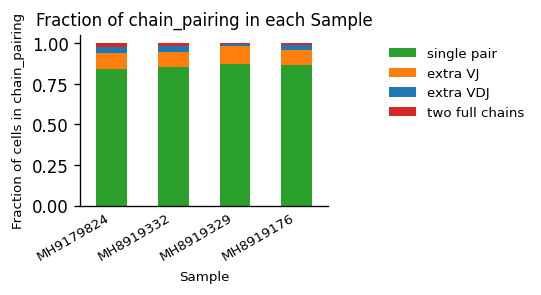

In [6]:
# Downsampling

adata = adata[adata.obs['patient_id'].isin(['COVID-014','COVID-045','COVID-066','COVID-067'])]
#adata[adata.obs['Status'] == 'Healthy'].obs['patient_id']
ir.pl.group_abundance(adata, groupby='Sample', target_col='chain_pairing', normalize=True)

# Clonotype definition

First, it is necessary to compute a distance of similarity/identity between the different unique nucleotide or amino acid sequences for both chains, VJ and VDJ. The distance matrix is located at adata.uns and is used to match cells 

In [7]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")

  0%|          | 0/8858 [00:00<?, ?it/s]

In [8]:
ir.tl.clonotype_network(adata, min_cells=2)

<AxesSubplot:>

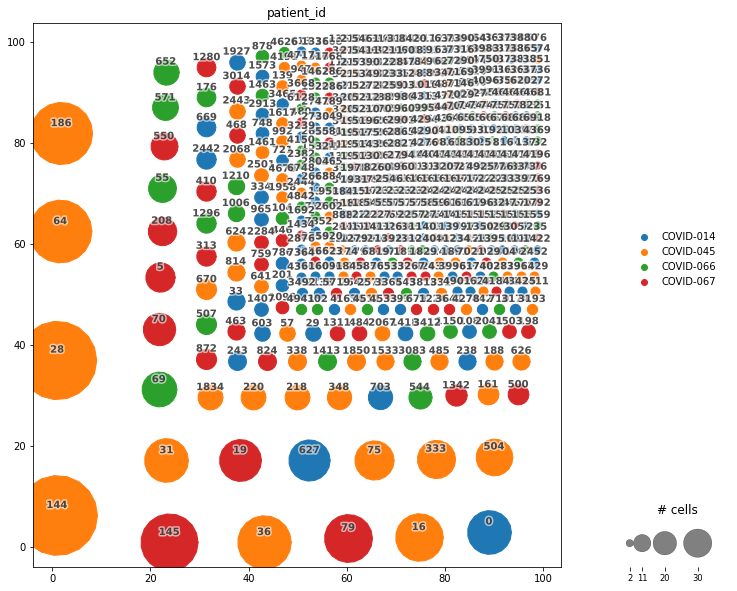

In [9]:
ir.pl.clonotype_network(
    adata, color="patient_id"
)

# Based on aa

In [10]:
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

  0%|          | 0/17391 [00:00<?, ?it/s]

  0%|          | 0/16836 [00:00<?, ?it/s]

In [11]:
ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

  0%|          | 0/8936 [00:00<?, ?it/s]

<AxesSubplot:>

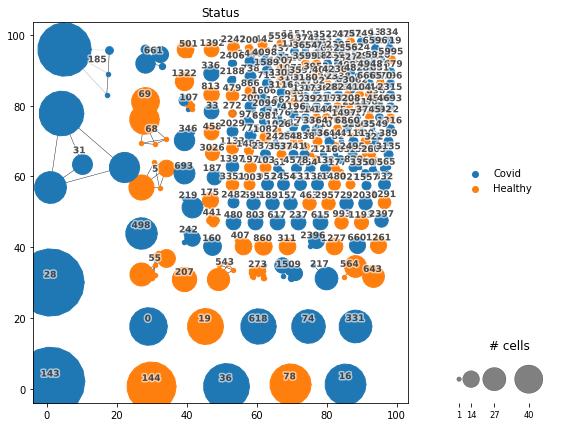

In [13]:
ir.tl.clonotype_network(adata, min_cells=3, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    adata, color="Status", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [69]:
adata

AnnData object with n_obs × n_vars = 10531 × 0
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'Centre', 'Sample', '

In [14]:
adata.obs.loc[adata.obs["cc_aa_alignment"] == "55", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CAMSAIDMEYGNKLVF,CAANPLPSGGYNKLIF,CATSGPGLGFLNEQFF,CASSPTSGGALETQYF,TRA+TRB,1
1,CAMSAIDMEYGNKLVF,CAVEHWSNYQLIW,CATSGPGLGFLNEQFF,CASTNRGTEAFF,TRA+TRB,1


# Including V gene

In [15]:
ir.tl.define_clonotype_clusters(
    adata,
    sequence="aa",
    metric="alignment",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="cc_aa_alignment_same_v",
)

  0%|          | 0/8938 [00:00<?, ?it/s]

In [16]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = adata.obs.groupby("cc_aa_alignment").apply(
    lambda x: x["cc_aa_alignment_same_v"].nunique() > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()
ct_different_v


['24',
 '28',
 '44',
 '82',
 '107',
 '243',
 '256',
 '272',
 '273',
 '425',
 '487',
 '537',
 '779',
 '805',
 '840',
 '864',
 '981',
 '1026',
 '1110',
 '1133',
 '1248',
 '1317',
 '1436',
 '1483',
 '1509',
 '1517',
 '1762',
 '1790',
 '1910',
 '2188',
 '2397',
 '2425',
 '2435',
 '2967',
 '3051',
 '3150',
 '3265',
 '3492',
 '4172',
 '4828',
 '4950',
 '5329',
 '5624',
 '5724',
 '5811',
 '5910',
 '5955',
 '6513',
 '6594',
 '6822',
 '7714']

In [17]:
adata.obs.loc[
    adata.obs["cc_aa_alignment"].isin(ct_different_v),
    [
        "cc_aa_alignment",
        "cc_aa_alignment_same_v",
        "IR_VJ_1_v_call",
        "IR_VDJ_1_v_call",
    ],
].sort_values("cc_aa_alignment").drop_duplicates().reset_index(drop=True)

,cc_aa_alignment,cc_aa_alignment_same_v,IR_VJ_1_v_call,IR_VDJ_1_v_call
0,24,24,TRAV10,TRBV6-4
1,24,2297,TRAV21,TRBV7-3
2,28,28,TRAV19,TRBV4-3
3,28,2723,TRAV18,TRBV4-3
4,44,4759,TRAV5,TRBV3-1
...,...,...,...,...
126,6594,7878,TRAV13-1,TRBV6-5
127,6822,8330,TRAV8-1,TRBV5-8
128,6822,6870,TRAV8-1,TRBV2
129,7714,8654,TRAV8-1,TRBV9


# Public vs privet clonotypes

# Clonal expansion

In [18]:
ir.tl.clonal_expansion(adata)

<AxesSubplot:>

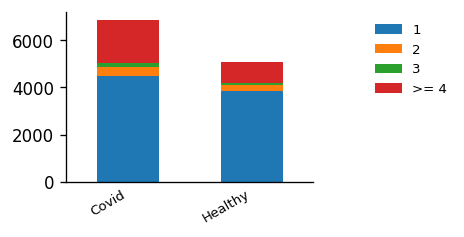

In [20]:
ir.pl.clonal_expansion(adata, groupby="Status", clip_at=4, normalize=False)

# Similarity and overlaps

In [21]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "patient_id", inplace=False)
df.head()

clone_id,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
patient_id,,,,,,,,,,,,,,,,,,,,,
COVID-014,71.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
COVID-045,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
COVID-066,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-067,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


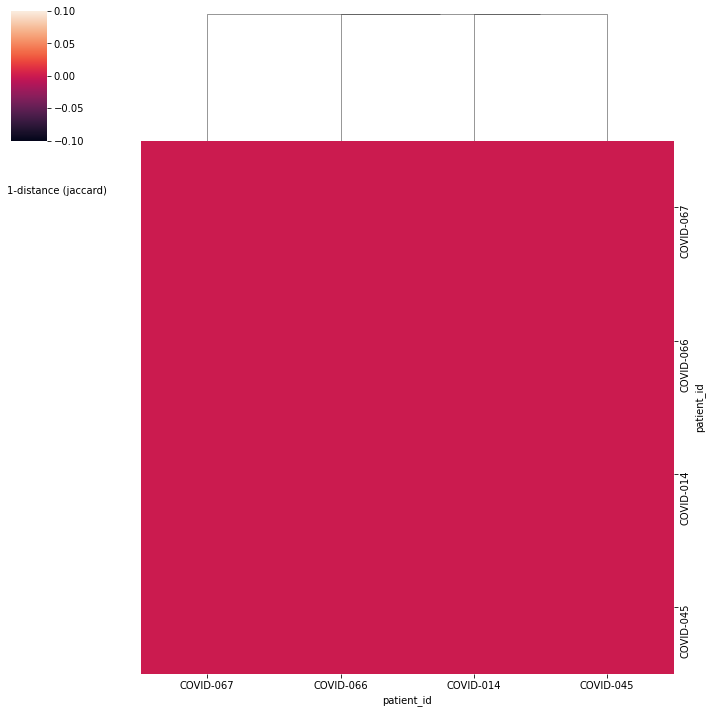

In [22]:
ir.pl.repertoire_overlap(adata, "patient_id")